In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost 
import lightgbm 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


##### TIME SERIES ANALYSIS

In [2]:
df_prices = pd.read_csv(r'C:\Users\harsh\bsesn.csv', thousands=',')
print(df_prices.head())
print(df_prices.size)

           Date     Price      Open      High       Low  Volume  Change  \
0  Dec 31, 2015  26117.54  25980.86  26147.63  25941.91   6.38K   0.61%   
1  Jan 01, 2016  26160.90  26101.50  26197.27  26008.20   6.06K   0.17%   
2  Jan 04, 2016  25623.35  26116.52  26116.52  25596.57   9.44K  -2.05%   
3  Jan 05, 2016  25580.34  25744.70  25766.76  25513.75  10.57K  -0.17%   
4  Jan 06, 2016  25406.33  25628.23  25632.57  25357.70  13.81K  -0.68%   

   Unnamed: 7  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  
9904


In [3]:
#Converting Date column to datetime datatype
df_prices['Date'] = pd.to_datetime(df_prices['Date'])
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1238 entries, 0 to 1237
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1237 non-null   datetime64[ns]
 1   Price       1237 non-null   float64       
 2   Open        1237 non-null   float64       
 3   High        1237 non-null   float64       
 4   Low         1237 non-null   float64       
 5   Volume      1237 non-null   object        
 6   Change      1237 non-null   object        
 7   Unnamed: 7  0 non-null      float64       
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 77.5+ KB


In [4]:
df_prices.drop(columns=['Unnamed: 7'],inplace=True)

In [5]:
df_prices.dropna(inplace = True)

In [6]:
df_prices

,Date,Price,Open,High,Low,Volume,Change
0,2015-12-31,26117.54,25980.86,26147.63,25941.91,6.38K,0.61%
1,2016-01-01,26160.90,26101.50,26197.27,26008.20,6.06K,0.17%
2,2016-01-04,25623.35,26116.52,26116.52,25596.57,9.44K,-2.05%
3,2016-01-05,25580.34,25744.70,25766.76,25513.75,10.57K,-0.17%
4,2016-01-06,25406.33,25628.23,25632.57,25357.70,13.81K,-0.68%
...,...,...,...,...,...,...,...
1232,2020-12-23,46444.18,46072.30,46513.32,45899.10,10.47M,0.95%
1233,2020-12-24,46973.54,46743.49,47053.40,46539.02,13.71M,1.14%
1234,2020-12-28,47353.75,47153.59,47406.72,47148.24,9.59M,0.81%
1235,2020-12-29,47613.08,47466.62,47714.55,47361.90,12.76M,0.55%


Text(0, 0.5, 'Price')

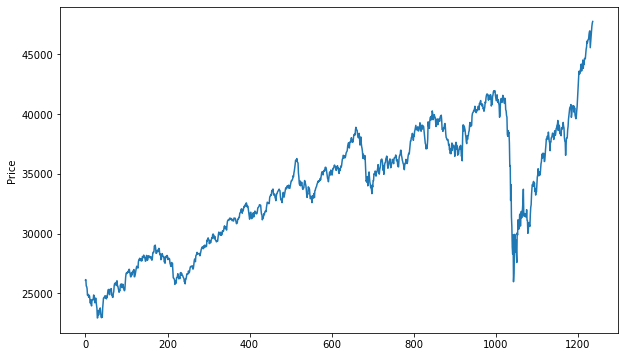

In [7]:
plt.figure(figsize=(10, 6))
df_prices['Price'].plot()
plt.ylabel('Price')

In [8]:
df_prices

,Date,Price,Open,High,Low,Volume,Change
0,2015-12-31,26117.54,25980.86,26147.63,25941.91,6.38K,0.61%
1,2016-01-01,26160.90,26101.50,26197.27,26008.20,6.06K,0.17%
2,2016-01-04,25623.35,26116.52,26116.52,25596.57,9.44K,-2.05%
3,2016-01-05,25580.34,25744.70,25766.76,25513.75,10.57K,-0.17%
4,2016-01-06,25406.33,25628.23,25632.57,25357.70,13.81K,-0.68%
...,...,...,...,...,...,...,...
1232,2020-12-23,46444.18,46072.30,46513.32,45899.10,10.47M,0.95%
1233,2020-12-24,46973.54,46743.49,47053.40,46539.02,13.71M,1.14%
1234,2020-12-28,47353.75,47153.59,47406.72,47148.24,9.59M,0.81%
1235,2020-12-29,47613.08,47466.62,47714.55,47361.90,12.76M,0.55%


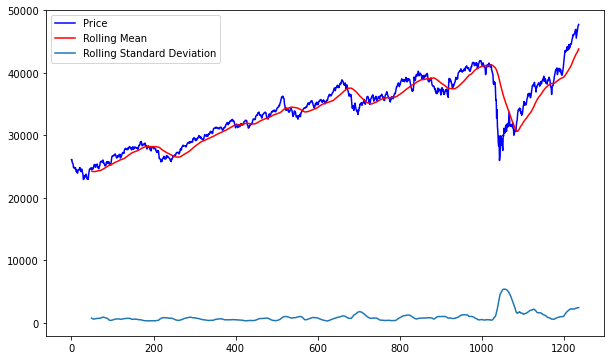

In [9]:
#Plotting moving average
close = df_prices['Price']
ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(10, 6))
df_prices['Price'].plot(color = 'b', label = 'Price')
ma.plot(color = 'r', label = 'Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')
plt.legend()

Text(0.5, 1.0, 'Returns')

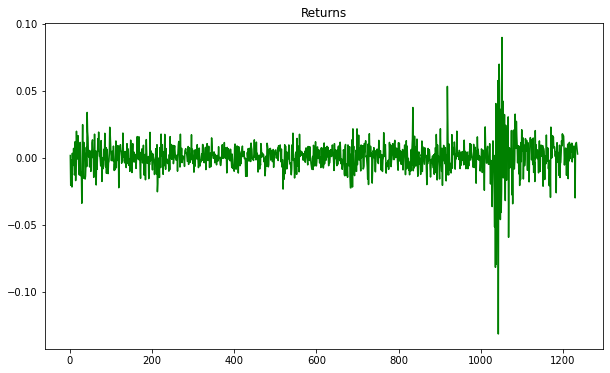

In [10]:
#Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize = (10,6))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

In [11]:
train = df_prices[:700]
test = df_prices[700:]

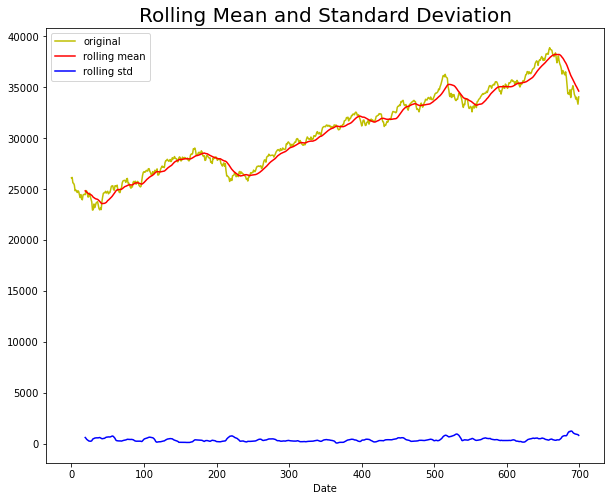

Results of dickey fuller test
ADF Test Statistic : -0.9675315910723534
p-value : 0.7649214871050706
#Lags Used : 1
Number of Observations Used : 698
Weak evidence against null hypothesis, time series is non-stationary 


In [12]:
#Stationarity test
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    #Plot rolling statistics:
    plt.figure(figsize = (10,8))
    plt.plot(timeseries, color = 'y', label = 'original')
    plt.plot(rolmean, color = 'r', label = 'rolling mean')
    plt.plot(rolstd, color = 'b', label = 'rolling std')
    plt.xlabel('Date')
    plt.legend()
    plt.title('Rolling Mean and Standard Deviation',  fontsize = 20)
    plt.show(block = False)
    print('Results of dickey fuller test')
    result = adfuller(timeseries, autolag = 'AIC')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result, labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(train['Price'])

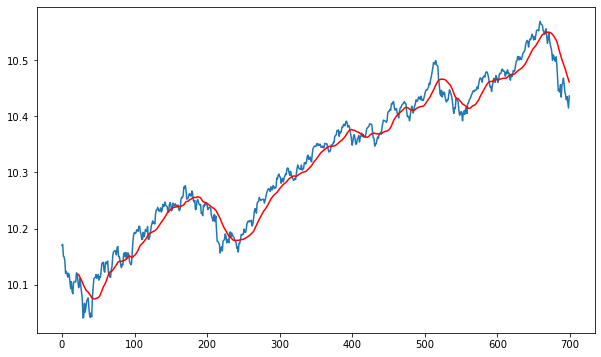

In [13]:
train_log = np.log(train['Price']) 
test_log = np.log(test['Price'])

mav = train_log.rolling(24).mean() 
plt.figure(figsize = (10,6))
plt.plot(train_log) 
plt.plot(mav, color = 'red') 

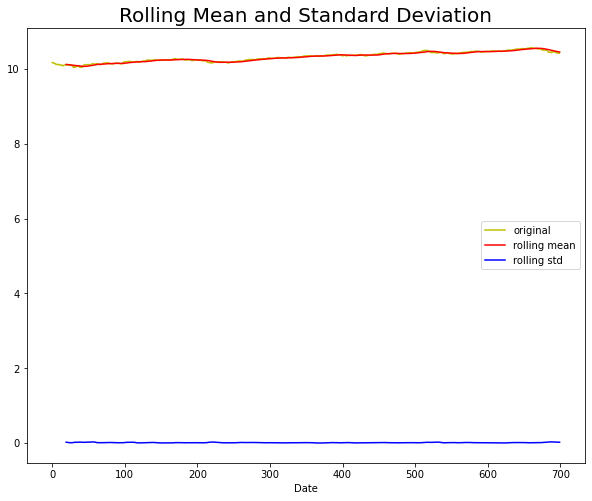

Results of dickey fuller test
ADF Test Statistic : -1.1416243061227187
p-value : 0.6981905312166929
#Lags Used : 4
Number of Observations Used : 695
Weak evidence against null hypothesis, time series is non-stationary 


In [14]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

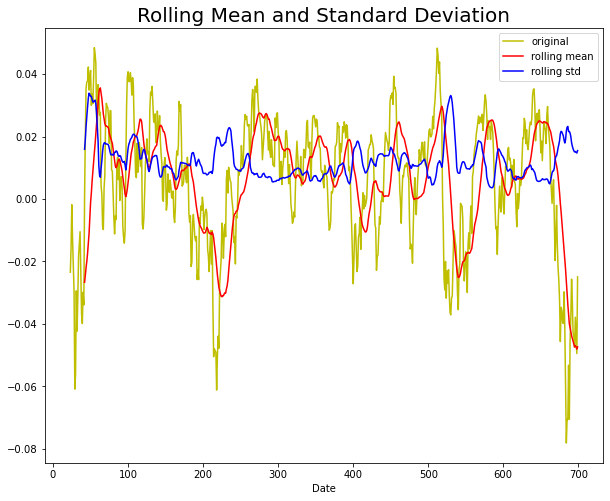

Results of dickey fuller test
ADF Test Statistic : -4.980202711120555
p-value : 2.428492327763878e-05
#Lags Used : 1
Number of Observations Used : 675
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [15]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)

In [16]:
#Using auto arima to make predictions using log data
from pmdarima import auto_arima
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(n_periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4809.298, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4811.652, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4813.252, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4813.333, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4811.960, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4811.541, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4811.476, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4809.649, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4813.840, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4811.971, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-4811.941, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4813.771, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-4810.088, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.498 seconds


Text(0, 0.5, 'Actual Stock Price')

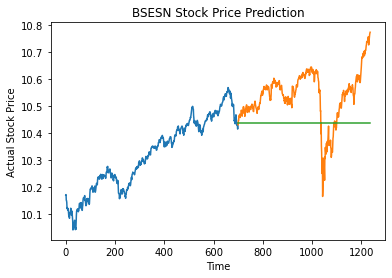

In [17]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

In [18]:
#Calculating error
rms = np.sqrt(mean_squared_error(test_log,predictions))
print("RMSE : ", rms)

RMSE :  0.13912461561187295


TEXTUAL ANALYSIS

In [19]:
cols = ['Date','Category','News']
df_news = pd.read_csv(r'C:\Users\harsh\india-news-headlines.csv', names = cols)
df_news

,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa
...,...,...,...
3424063,20201231,city.jodhpur,Covid-19: Despite dip in cases; Rajasthan amon...
3424064,20201231,city.udaipur,Covid-19: Despite dip in cases; Rajasthan amon...
3424065,20201231,city.ajmer,Covid-19: Despite dip in cases; Rajasthan amon...
3424066,20201231,removed,Govt extends deadline for use of FASTag till F...


In [20]:
df_news.drop(0, inplace=True)
df_news.drop('Category', axis = 1, inplace=True)
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3424067 entries, 1 to 3424067
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Date    object
 1   News    object
dtypes: object(2)
memory usage: 78.4+ MB


In [21]:
 #Converting data type of Date column 
df_news['Date'] = pd.to_datetime(df_news['Date'],format= '%Y%m%d')
df_news

,Date,News
1,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-02,Fissures in Hurriyat over Pak visit
3,2001-01-02,America's unwanted heading for India?
4,2001-01-02,For bigwigs; it is destination Goa
5,2001-01-02,Extra buses to clear tourist traffic
...,...,...
3424063,2020-12-31,Covid-19: Despite dip in cases; Rajasthan amon...
3424064,2020-12-31,Covid-19: Despite dip in cases; Rajasthan amon...
3424065,2020-12-31,Covid-19: Despite dip in cases; Rajasthan amon...
3424066,2020-12-31,Govt extends deadline for use of FASTag till F...


In [22]:
df_news=df_news[df_news['Date']>="2015-12-31"]

In [23]:
#Grouping the headlines for each day
df_news['News'] = df_news.groupby(['Date']).transform(lambda x : ' '.join(x)) 
df_news = df_news.drop_duplicates() 
df_news.reset_index(inplace = True, drop = True)
df_news

,Date,News
0,2015-12-31,Answers to your food choices 7 must-try teas f...
1,2016-01-01,In pics: 6 winter foods that help you lose wei...
2,2016-01-02,4 foods to detox your system Things that happe...
3,2016-01-03,5-point gym protocol to follow 7 effective det...
4,2016-01-04,Surprising facts about exercise sweat Bizarre ...
...,...,...
1823,2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
1824,2020-12-28,Horoscope Today; 28 December 2020: Check astro...
1825,2020-12-29,Man recovers charred remains of 'thief' from h...
1826,2020-12-30,Numerology Readings 30 December 2020: Predicti...


In [24]:
df_news['News']

0       Answers to your food choices 7 must-try teas f...
1       In pics: 6 winter foods that help you lose wei...
2       4 foods to detox your system Things that happe...
3       5-point gym protocol to follow 7 effective det...
4       Surprising facts about exercise sweat Bizarre ...
                              ...                        
1823    #BigInterview! Dhritiman Chatterjee: Nobody da...
1824    Horoscope Today; 28 December 2020: Check astro...
1825    Man recovers charred remains of 'thief' from h...
1826    Numerology Readings 30 December 2020: Predicti...
1827    Horoscope Today; 31 December 2020: Check astro...
Name: News, Length: 1828, dtype: object

In [26]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
  
ps = PorterStemmer()

In [27]:
#Cleaning headlines
c = []
for i in range(0,len(df_news['News'])):
    news = re.sub('[^a-zA-Z]',' ',df_news['News'][i])
    news = news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if not word in set(stopwords.words('english'))]
    news=' '.join(news)
    c.append(news)

In [28]:
df_news['News'] = pd.Series(c)
df_news

,Date,News
0,2015-12-31,answer food choic must tri tea healthier right...
1,2016-01-01,pic winter food help lose weight top health we...
2,2016-01-02,food detox system thing happen women sex craft...
3,2016-01-03,point gym protocol follow effect detox food qu...
4,2016-01-04,surpris fact exercis sweat bizarr home remedi ...
...,...,...
1823,2020-12-27,biginterview dhritiman chatterje nobodi dare m...
1824,2020-12-28,horoscop today decemb check astrolog predict a...
1825,2020-12-29,man recov char remain thief burnt shop dump be...
1826,2020-12-30,numerolog read decemb predict lucki colour luc...


In [29]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return  TextBlob(text).sentiment.polarity

In [30]:
#Adding subjectivity and polarity columns
df_news['Subjectivity'] = df_news['News'].apply(getSubjectivity)
df_news['Polarity'] = df_news['News'].apply(getPolarity)
df_news

,Date,News,Subjectivity,Polarity
0,2015-12-31,answer food choic must tri tea healthier right...,0.405949,0.084809
1,2016-01-01,pic winter food help lose weight top health we...,0.396936,0.079459
2,2016-01-02,food detox system thing happen women sex craft...,0.464979,0.085414
3,2016-01-03,point gym protocol follow effect detox food qu...,0.395856,0.076718
4,2016-01-04,surpris fact exercis sweat bizarr home remedi ...,0.402258,0.035205
...,...,...,...,...
1823,2020-12-27,biginterview dhritiman chatterje nobodi dare m...,0.366994,0.058187
1824,2020-12-28,horoscop today decemb check astrolog predict a...,0.395275,0.085493
1825,2020-12-29,man recov char remain thief burnt shop dump be...,0.399135,0.068856
1826,2020-12-30,numerolog read decemb predict lucki colour luc...,0.389012,0.040116


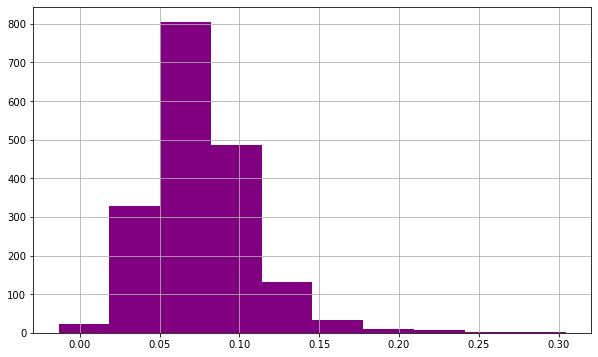

In [31]:
plt.figure(figsize = (10,6))
df_news['Polarity'].hist(color = 'purple')

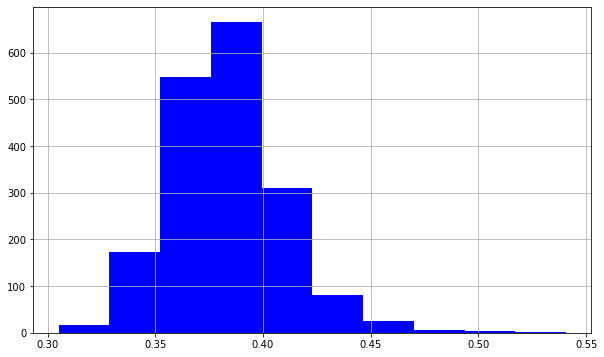

In [32]:
plt.figure(figsize = (10,6))
df_news['Subjectivity'].hist(color = 'blue')

In [33]:
#Adding sentiment score to df_news
sia = SentimentIntensityAnalyzer()

df_news['Compound'] = [sia.polarity_scores(v)['compound'] for v in df_news['News']]
df_news['Negative'] = [sia.polarity_scores(v)['neg'] for v in df_news['News']]
df_news['Neutral'] = [sia.polarity_scores(v)['neu'] for v in df_news['News']]
df_news['Positive'] = [sia.polarity_scores(v)['pos'] for v in df_news['News']]
df_news

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2015-12-31,answer food choic must tri tea healthier right...,0.405949,0.084809,-0.9997,0.144,0.762,0.094
1,2016-01-01,pic winter food help lose weight top health we...,0.396936,0.079459,-0.9994,0.121,0.787,0.092
2,2016-01-02,food detox system thing happen women sex craft...,0.464979,0.085414,-0.9999,0.151,0.759,0.090
3,2016-01-03,point gym protocol follow effect detox food qu...,0.395856,0.076718,-0.9999,0.179,0.733,0.087
4,2016-01-04,surpris fact exercis sweat bizarr home remedi ...,0.402258,0.035205,-0.9997,0.139,0.769,0.091
...,...,...,...,...,...,...,...,...
1823,2020-12-27,biginterview dhritiman chatterje nobodi dare m...,0.366994,0.058187,-0.9998,0.145,0.786,0.068
1824,2020-12-28,horoscop today decemb check astrolog predict a...,0.395275,0.085493,-0.9996,0.120,0.807,0.074
1825,2020-12-29,man recov char remain thief burnt shop dump be...,0.399135,0.068856,-0.9998,0.145,0.782,0.073
1826,2020-12-30,numerolog read decemb predict lucki colour luc...,0.389012,0.040116,-0.9999,0.149,0.782,0.069


In [34]:
df_merge = pd.merge(df_prices, df_news, how='inner', on='Date')
df_merge

,Date,Price,Open,High,Low,Volume,Change,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2015-12-31,26117.54,25980.86,26147.63,25941.91,6.38K,0.61%,answer food choic must tri tea healthier right...,0.405949,0.084809,-0.9997,0.144,0.762,0.094
1,2016-01-01,26160.90,26101.50,26197.27,26008.20,6.06K,0.17%,pic winter food help lose weight top health we...,0.396936,0.079459,-0.9994,0.121,0.787,0.092
2,2016-01-04,25623.35,26116.52,26116.52,25596.57,9.44K,-2.05%,surpris fact exercis sweat bizarr home remedi ...,0.402258,0.035205,-0.9997,0.139,0.769,0.091
3,2016-01-05,25580.34,25744.70,25766.76,25513.75,10.57K,-0.17%,top weight manag tip travel depress find simpl...,0.376177,0.074015,-0.9999,0.162,0.753,0.085
4,2016-01-06,25406.33,25628.23,25632.57,25357.70,13.81K,-0.68%,way say stress exercis tone thigh guid correct...,0.401723,0.087999,-0.9989,0.126,0.768,0.106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1232,2020-12-23,46444.18,46072.30,46513.32,45899.10,10.47M,0.95%,sawmil makarpura gidc gut none hurt civic bodi...,0.368617,0.091200,-0.9999,0.145,0.789,0.066
1233,2020-12-24,46973.54,46743.49,47053.40,46539.02,13.71M,1.14%,set mood sex cold winter two hous blow gujarat...,0.386303,0.065157,-0.9995,0.116,0.809,0.075
1234,2020-12-28,47353.75,47153.59,47406.72,47148.24,9.59M,0.81%,horoscop today decemb check astrolog predict a...,0.395275,0.085493,-0.9996,0.120,0.807,0.074
1235,2020-12-29,47613.08,47466.62,47714.55,47361.90,12.76M,0.55%,man recov char remain thief burnt shop dump be...,0.399135,0.068856,-0.9998,0.145,0.782,0.073


In [36]:
df = df_merge[['Price','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
df

,Price,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,26117.54,0.405949,0.084809,-0.9997,0.144,0.762,0.094
1,26160.90,0.396936,0.079459,-0.9994,0.121,0.787,0.092
2,25623.35,0.402258,0.035205,-0.9997,0.139,0.769,0.091
3,25580.34,0.376177,0.074015,-0.9999,0.162,0.753,0.085
4,25406.33,0.401723,0.087999,-0.9989,0.126,0.768,0.106
...,...,...,...,...,...,...,...
1232,46444.18,0.368617,0.091200,-0.9999,0.145,0.789,0.066
1233,46973.54,0.386303,0.065157,-0.9995,0.116,0.809,0.075
1234,47353.75,0.395275,0.085493,-0.9996,0.120,0.807,0.074
1235,47613.08,0.399135,0.068856,-0.9998,0.145,0.782,0.073


In [37]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
new_df = pd.DataFrame(sc.fit_transform(df))
new_df.columns = df.columns
new_df.index = df.index
new_df.head()

,Price,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.127678,0.402011,0.308655,0.000153,0.563107,0.279661,0.580247
1,0.129427,0.361985,0.291828,0.000306,0.339806,0.491525,0.555556
2,0.107747,0.385620,0.152642,0.000153,0.514563,0.338983,0.543210
3,0.106012,0.269805,0.274704,0.000051,0.737864,0.203390,0.469136
4,0.098994,0.383242,0.318687,0.000561,0.388350,0.330508,0.728395


In [39]:
X = new_df.drop('Price', axis=1)
y =new_df['Price']

In [40]:
X.head()

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.402011,0.308655,0.000153,0.563107,0.279661,0.580247
1,0.361985,0.291828,0.000306,0.339806,0.491525,0.555556
2,0.385620,0.152642,0.000153,0.514563,0.338983,0.543210
3,0.269805,0.274704,0.000051,0.737864,0.203390,0.469136
4,0.383242,0.318687,0.000561,0.388350,0.330508,0.728395


In [41]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
x_train.shape

(989, 6)

In [42]:
x_train[:10]

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
1015,0.222508,0.173891,0.000102,0.650485,0.313559,0.419753
853,0.327196,0.206704,0.000102,0.601942,0.432203,0.308642
784,0.174744,0.297514,0.000102,0.757282,0.186441,0.481481
406,0.146931,0.170616,0.000102,0.427184,0.533898,0.382716
981,0.380534,0.246608,0.000102,0.563107,0.372881,0.444444
822,0.445076,0.290966,0.000102,0.582524,0.406780,0.370370
402,0.277431,0.175272,1.000000,0.194175,0.457627,0.790123
1039,0.207740,0.166533,0.000051,0.854369,0.288136,0.197531
302,0.266636,0.191675,0.000051,0.708738,0.245763,0.444444
1181,0.062206,0.214883,0.000051,0.757282,0.415254,0.135802


In [43]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)

In [44]:
print(prediction[:10])
print(y_test[:10])
print(mean_squared_error(prediction,y_test))

[0.31862762 0.33098592 0.65256806 0.45723435 0.30613746 0.30983327
 0.6148341  0.56211535 0.64532933 0.68376334]
308     0.270045
152     0.197939
875     0.652535
503     0.463058
351     0.335619
18      0.062133
1001    0.732567
1095    0.426973
995     0.766335
933     0.615568
Name: Price, dtype: float64
0.03170056481822039


In [45]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)
predictions = adb.predict(x_test)

In [46]:
print(mean_squared_error(predictions, y_test))

0.03573659574382308


In [47]:
from sklearn.tree import DecisionTreeRegressor
dec_tree = DecisionTreeRegressor()
dec_tree.fit(x_train, y_train)
predictions = dec_tree.predict(x_test)

In [48]:
print(predictions[:10])
print(y_test[:10])
print(mean_squared_error(predictions,y_test))

[0.19043703 0.28935497 0.67201653 0.14926683 0.16800212 0.33014565
 0.67042343 0.9064607  0.57024956 0.7205626 ]
308     0.270045
152     0.197939
875     0.652535
503     0.463058
351     0.335619
18      0.062133
1001    0.732567
1095    0.426973
995     0.766335
933     0.615568
Name: Price, dtype: float64
0.05859914990578003


In [49]:
lgb = lightgbm.LGBMRegressor()
lgb.fit(x_train, y_train)

LGBMRegressor()

In [50]:
predictions = lgb.predict(x_test)
print(mean_squared_error(predictions,y_test))

0.03362574968370159


In [51]:
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [52]:
predictions = xgb.predict(x_test)
print(mean_squared_error(predictions,y_test))

0.03284519975362974


We observe that Adaboost model performs the best for the sentiment analysis